In [2]:
#Libraries
import pickle
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from datetime import datetime
from tqdm import tqdm,tqdm_notebook
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#1. Loading Data

In [3]:
diab_data=pd.read_csv('/content/Diabetes-Prediction/data/diabetes_data.csv')
print(diab_data.shape)
diab_data.head(5)

(768, 10)


,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


In [4]:
#checking missing values
print('Num of missing values are : ',diab_data.isna().sum().sum())
#Dropping Duplicate rows
diab_data.drop_duplicates(inplace=True)
diab_data.shape

Num of missing values are :  0


(768, 10)

#2. Train Test Split

In [5]:
diabetes_lst=[]
for i in diab_data['diabetes'].values:
  if i==True:
    diabetes_lst.append(1)
  else:
    diabetes_lst.append(0)

#replacing true/false with 1/0
diab_data['diabetes']=diabetes_lst

X=diab_data.drop('diabetes',axis=1)
y=diab_data['diabetes']

In [6]:
#Splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(576, 9) (576,)
(192, 9) (192,)


#2. EDA

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 751 to 107
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_preg      576 non-null    int64  
 1   glucose_conc  576 non-null    int64  
 2   diastolic_bp  576 non-null    int64  
 3   thickness     576 non-null    int64  
 4   insulin       576 non-null    int64  
 5   bmi           576 non-null    float64
 6   diab_pred     576 non-null    float64
 7   age           576 non-null    int64  
 8   skin          576 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 45.0 KB


In [8]:
X_train.describe()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,3.831597,120.767361,69.170139,20.723958,77.899306,32.064583,0.480200,33.536458,0.816524
std,3.312864,31.771380,18.699887,15.877307,107.415003,7.861032,0.333188,11.878752,0.625566
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.600000,0.245750,24.000000,0.000000
50%,3.000000,116.500000,72.000000,23.000000,40.000000,32.400000,0.384000,30.000000,0.906200
75%,6.000000,141.000000,80.000000,32.000000,129.250000,36.525000,0.646250,41.000000,1.260800
max,17.000000,199.000000,122.000000,99.000000,744.000000,67.100000,2.329000,81.000000,3.900600


<BarContainer object of 2 artists>

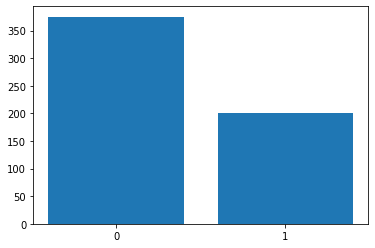

In [9]:
#Checking class imbalance.
labels_dt=dict(Y_train.value_counts())
plt.bar(['0','1'],list(labels_dt.values()))

#Feature Selection

In [10]:
X_train.corr()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin
num_preg,1.000000,0.143560,0.100853,-0.107152,-0.044307,0.003597,-0.061516,0.523782,-0.107152
glucose_conc,0.143560,1.000000,0.147956,0.036734,0.347588,0.188119,0.125984,0.289533,0.036734
diastolic_bp,0.100853,0.147956,1.000000,0.161171,0.096122,0.271709,0.022236,0.220797,0.161171
thickness,-0.107152,0.036734,0.161171,1.000000,0.468928,0.364591,0.182539,-0.102407,1.000000
insulin,-0.044307,0.347588,0.096122,0.468928,1.000000,0.192899,0.238205,-0.018226,0.468928
bmi,0.003597,0.188119,0.271709,0.364591,0.192899,1.000000,0.132408,0.025166,0.364591
diab_pred,-0.061516,0.125984,0.022236,0.182539,0.238205,0.132408,1.000000,0.019768,0.182539
age,0.523782,0.289533,0.220797,-0.102407,-0.018226,0.025166,0.019768,1.000000,-0.102407
skin,-0.107152,0.036734,0.161171,1.000000,0.468928,0.364591,0.182539,-0.102407,1.000000


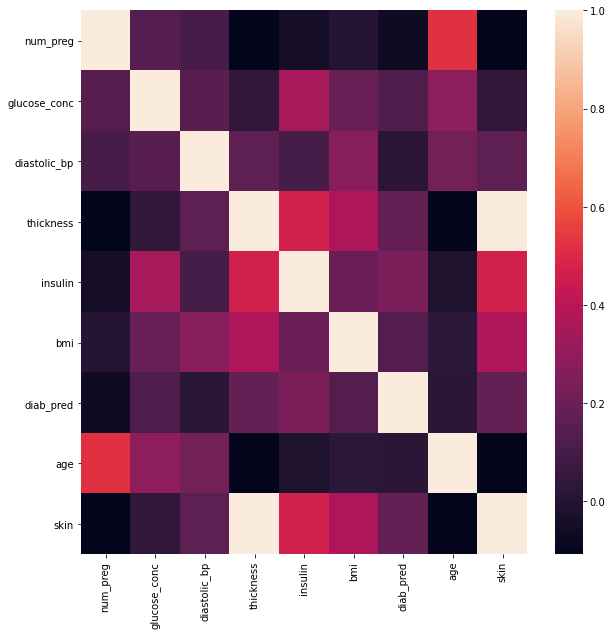

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr())

It is observed that skin and thickness are highly correlated. so removing skin feature

In [12]:
#dropping skin column
X_train=X_train.drop('skin',axis=1)
X_test=X_test.drop('skin',axis=1)

<BarContainer object of 8 artists>

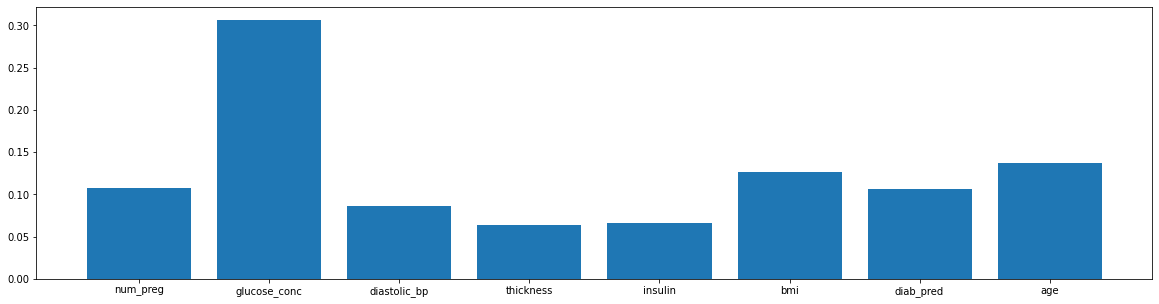

In [13]:
#feature_importance_
from sklearn.ensemble import ExtraTreesRegressor
rf=ExtraTreesRegressor()
rf.fit(X_train,Y_train)
feature_imp=rf.feature_importances_
features=X_train.columns
plt.figure(figsize=(20,5))
plt.bar(features,feature_imp)

It is observed that glucose_con is the most important feature in predicting the class labels.

In [14]:
col=list(X_train.columns)
#Imputing where value=0
from sklearn.impute import SimpleImputer
mean_impute=SimpleImputer(missing_values=0,strategy='mean')
X_train=mean_impute.fit_transform(X_train)
X_test=mean_impute.fit_transform(X_test)
X_train=pd.DataFrame(X_train, columns=col)
X_test=pd.DataFrame(X_test, columns=col)

In [15]:
#Upsampling the dataa using SMOOTE
from imblearn.over_sampling import SMOTE
X_train_up, Y_train_up = SMOTE(sampling_strategy={1.0:X_train.shape[0]}).fit_resample(X_train, Y_train)
X_train_up = pd.DataFrame(X_train_up, columns=col)
print(X_train_up.shape)
print(Y_train_up.shape)

(951, 8)
(951,)


In [ ]:
#Splitting data into train and cv
from sklearn.model_selection import train_test_split
X_train_up,X_cv,Y_train_up,Y_cv=train_test_split(X_train_up,Y_train_up,test_size=0.25,stratify=Y_train_up,random_state=42)
print(X_train_up.shape,Y_train_up.shape)
print(X_cv.shape,Y_cv.shape)

#Model Selection

In [47]:
#Metrics. 
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score

def custom_scorer(y_true, y_pred, actual_scorer):
  score = np.nan
  try:
      score = actual_scorer(y_true, y_pred)
  except ValueError: 
      pass
  return score

acc = make_scorer(accuracy_score)
recall = make_scorer(custom_scorer, actual_scorer=recall_score)
new_auc = make_scorer(custom_scorer, actual_scorer=roc_auc_score)
mcc = make_scorer(custom_scorer, actual_scorer=matthews_corrcoef)
bal_acc = make_scorer(custom_scorer,actual_scorer=balanced_accuracy_score)

#scoring = {"roc_auc_score": new_auc, "recall": recall, "MCC" : mcc, 'Bal_acc' : bal_acc, "Accuracy": acc }
#scoring_metrics = {"Accuracy": acc }

In [57]:
#function for printing the confusion matrix 
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
  C = confusion_matrix(test_y, predict_y)
  A =(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
  labels = [0,1]
  # representing A in heatmap format
  cmap=sns.light_palette("blue")
  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")
  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  plt.subplot(1, 3, 3)
  # representing B in heatmap format
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()

In [56]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
rf=RandomForestClassifier()
params={'n_estimators':[int(x) for x in np.linspace(10,1000,10)],
        'max_depth':[int(x) for x in np.linspace(3,200,10)],
        'max_features':['auto','sqrt','log'],
        'min_samples_split':[1,2,5,10,15],
        'min_samples_leaf':[1,2,5,10]
}
rand_rf=RandomizedSearchCV(rf,params,verbose=3,n_jobs=-1,cv=10,scoring=acc)
rand_rf.fit(X_train_up,Y_train_up)
print('Best Parameters obtained from RamdomSearchCV is:',rand_rf.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


Best Parameters obtained from RamdomSearchCV is: {'n_estimators': 560, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 112}


Train acc is :  0.9305993690851735
Test acc is :  0.734375
Train Confusion Matrix :-


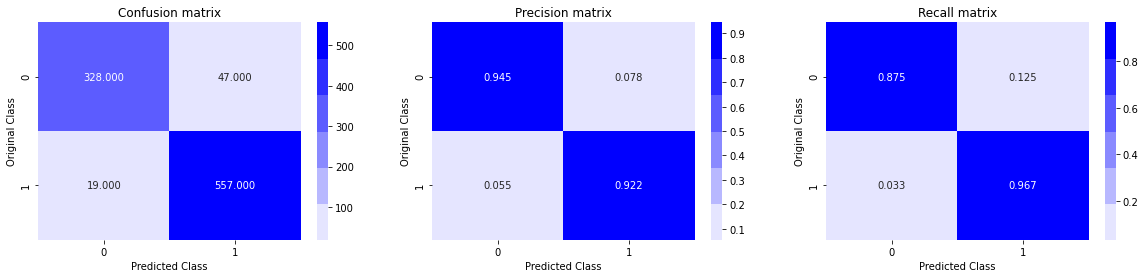

Test Confusion Matrix :-


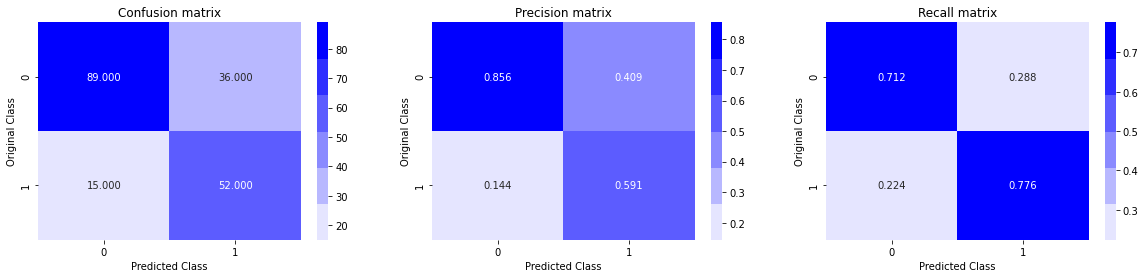

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve

y_train_pred=rand_rf.predict(X_train_up)
y_test_pred=rand_rf.predict(X_test)

print('Train acc is : ',accuracy_score(Y_train_up,y_train_pred))
print('Test acc is : ',accuracy_score(Y_test,y_test_pred))

print("Train Confusion Matrix :-")
plot_confusion_matrix(Y_train_up,y_train_pred)
print("Test Confusion Matrix :-")
plot_confusion_matrix(Y_test,y_test_pred)

In [65]:
#XGBClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
xgb=XGBClassifier()
params={'n_estimators':[int(x) for x in np.linspace(10,1000,10)],
        'max_depth':[int(x) for x in np.linspace(3,200,10)],
        'max_features':['auto','sqrt','log'],
        'min_samples_split':[1,2,5,10,15],
        'min_samples_leaf':[1,2,5,10]
}
rand_xgb=RandomizedSearchCV(xgb,params,verbose=3,n_jobs=-1,cv=10,scoring=acc)
rand_xgb.fit(X_train_up,Y_train_up)
print('Best Parameters obtained from RamdomSearchCV is:',rand_xgb.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.8s finished


Best Parameters obtained from RamdomSearchCV is: {'n_estimators': 560, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log', 'max_depth': 178}


Train acc is :  0.9305993690851735
Test acc is :  0.734375
Train Confusion Matrix :-


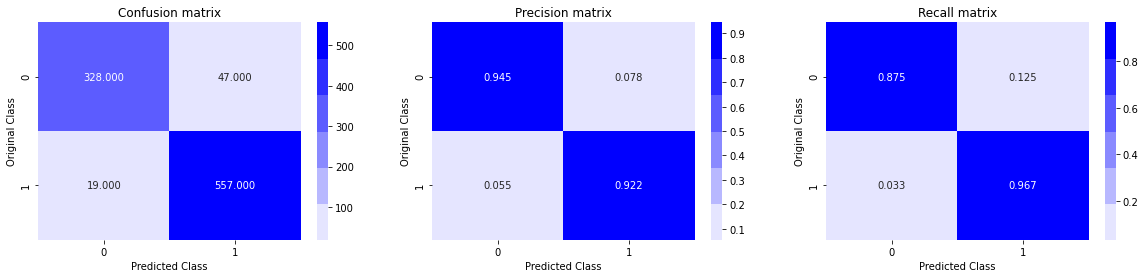

Test Confusion Matrix :-


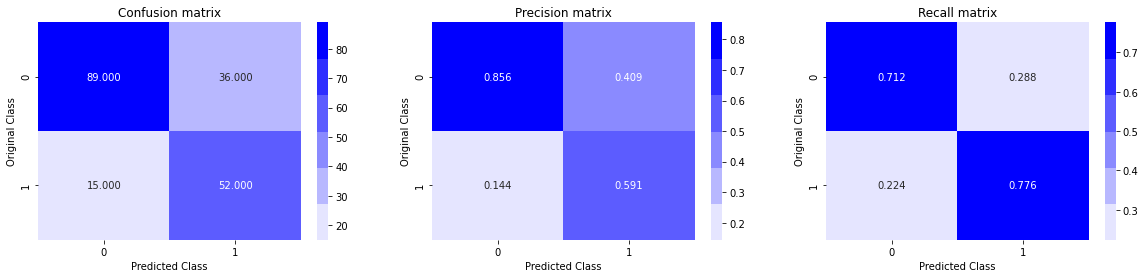

In [66]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve

y_train_pred=rand_rf.predict(X_train_up)
y_test_pred=rand_rf.predict(X_test)

print('Train acc is : ',accuracy_score(Y_train_up,y_train_pred))
print('Test acc is : ',accuracy_score(Y_test,y_test_pred))

print("Train Confusion Matrix :-")
plot_confusion_matrix(Y_train_up,y_train_pred)
print("Test Confusion Matrix :-")
plot_confusion_matrix(Y_test,y_test_pred)